In [1]:
!pip install fredapi yfinance pandas matplotlib --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


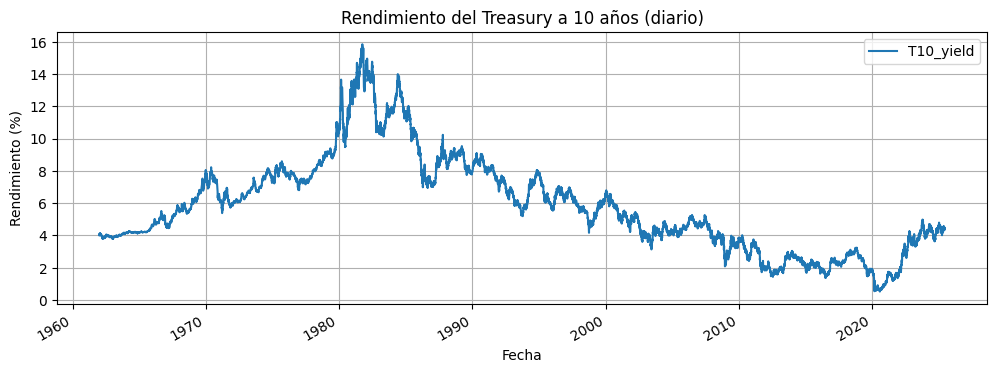

In [2]:
# ---------------------------------------------------------
# DESCARGA Y VISUALIZACIÓN DE LA TASA DEL TREASURY A 10 AÑOS (T10)
# ---------------------------------------------------------

from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Inicialización del cliente FRED con clave API personal
fred = Fred(api_key='9b74884541c442ef0b56869ce3105d01')

# Descarga de la serie diaria correspondiente al rendimiento del bono del Tesoro de EE.UU. a 10 años (DGS10)
t10 = fred.get_series('DGS10')
t10 = t10.dropna().to_frame(name='T10_yield')
t10.index.name = 'date'

# Visualización de la evolución histórica del rendimiento del T10
t10.plot(figsize=(12, 4), title='Rendimiento del Treasury a 10 años (diario)')
plt.ylabel('Rendimiento (%)')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

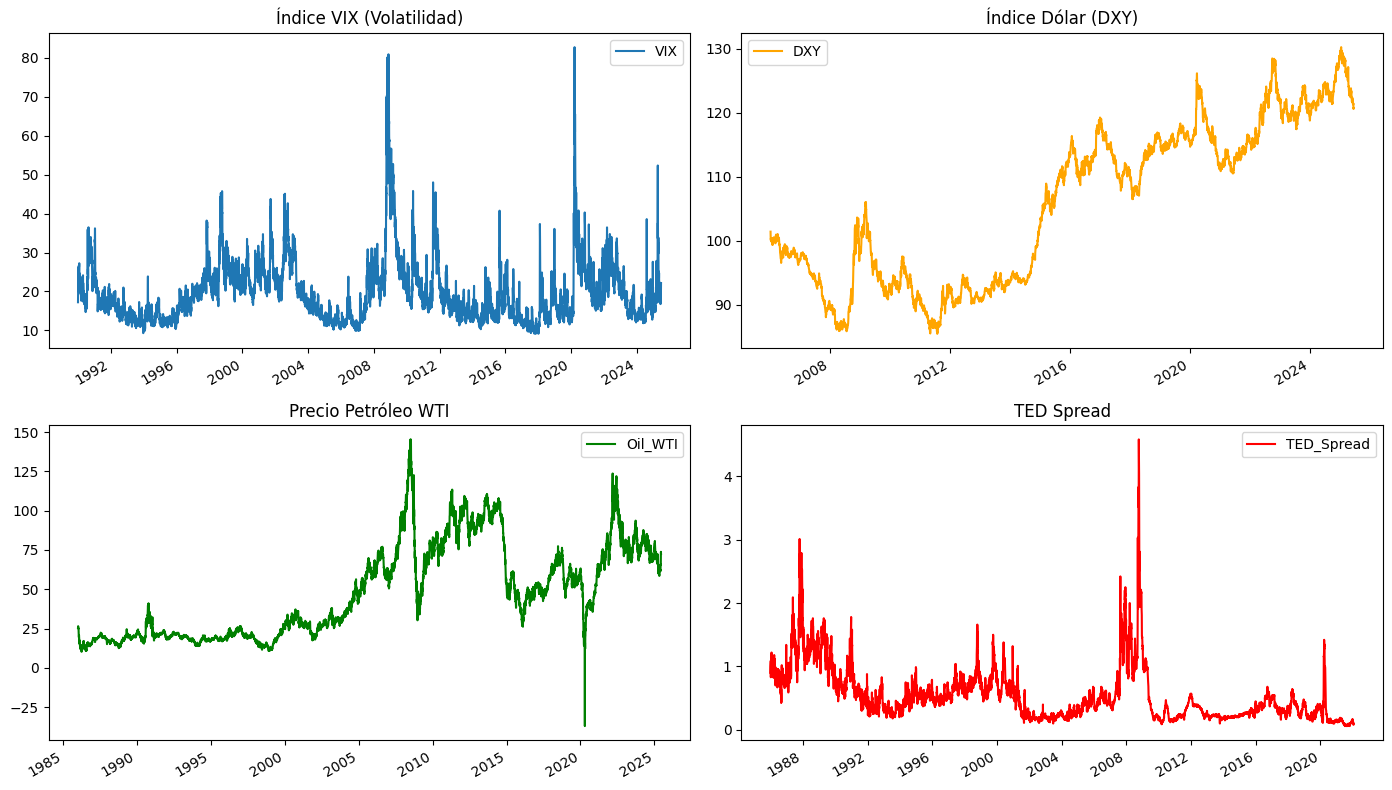

In [3]:
# ---------------------------------------------------------
# DESCARGA DE VARIABLES MACROFINANCIERAS DIARIAS
# ---------------------------------------------------------

# Descarga de variables desde FRED
vix = fred.get_series('VIXCLS').dropna().to_frame(name='VIX')
dxy = fred.get_series('DTWEXBGS').dropna().to_frame(name='DXY')
oil = fred.get_series('DCOILWTICO').dropna().to_frame(name='Oil_WTI')
ted = fred.get_series('TEDRATE').dropna().to_frame(name='TED_Spread')

# Visualización conjunta de las variables descargadas
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
vix.plot(ax=ax[0,0], title='Índice VIX (Volatilidad)')
dxy.plot(ax=ax[0,1], title='Índice Dólar (DXY)', color='orange')
oil.plot(ax=ax[1,0], title='Precio Petróleo WTI', color='green')
ted.plot(ax=ax[1,1], title='TED Spread', color='red')
plt.tight_layout()
plt.show()

/tmp/ipykernel_33981/3820780243.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_raw = yf.download('^GSPC', start='1990-01-01', progress=False)


Columnas disponibles en el DataFrame de S&P 500:
MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


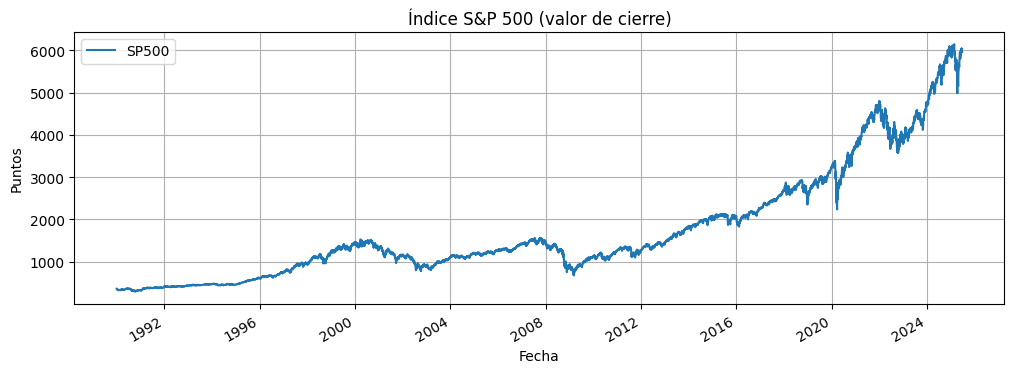

In [4]:
# ---------------------------------------------------------
# DESCARGA DEL ÍNDICE S&P 500 DESDE YAHOO FINANCE (MULTIINDEX CORREGIDO)
# ---------------------------------------------------------

import yfinance as yf

# Descarga del índice S&P 500 desde Yahoo Finance
# Alineado al resto de las variables macro utilizadas en el análisis
sp500_raw = yf.download('^GSPC', start='1990-01-01', progress=False)

# Confirmación de columnas disponibles bajo formato MultiIndex
print("Columnas disponibles en el DataFrame de S&P 500:")
print(sp500_raw.columns)

# Selección de la columna 'Close' del índice '^GSPC' utilizando acceso por tupla
sp500 = sp500_raw[('Close', '^GSPC')].dropna()
sp500.name = 'SP500'
sp500 = sp500.to_frame()

# Visualización de la evolución histórica del índice
sp500.plot(figsize=(12, 4), title='Índice S&P 500 (valor de cierre)')
plt.ylabel('Puntos')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

In [5]:
# ---------------------------------------------------------
# UNIFICACIÓN DE VARIABLES Y EXPORTACIÓN DE LA SABANA FINAL
# ---------------------------------------------------------

# Lista de todas las series previamente procesadas y alineadas
series = [t10, vix, dxy, oil, ted, sp500]

# Fusión iterativa de las series usando un join tipo "inner" por índice temporal (fecha)
# Se conservan solo aquellas fechas en las que todas las variables están disponibles
df_final = series[0]
for df in series[1:]:
    df_final = df_final.join(df, how='inner')

# Verificación rápida de la estructura del DataFrame final
print("\nVista preliminar del DataFrame unificado:")
display(df_final.head())

# Información general de la muestra disponible
print(f"Número total de observaciones: {df_final.shape[0]}")
print(f"Rango de fechas: {df_final.index.min().date()} → {df_final.index.max().date()}")

# Revisión de datos faltantes (debería ser 0 si el join fue exitoso)
print("\nConteo de valores nulos por variable:")
print(df_final.isnull().sum())

# Exportación de la sabana a un archivo CSV para uso posterior
df_final.to_csv("sabana_macro_t10.csv", index=True)

print("\n✅ Sabana exportada exitosamente como 'sabana_macro_t10.csv'")


Vista preliminar del DataFrame unificado:


,T10_yield,VIX,DXY,Oil_WTI,TED_Spread,SP500
2006-01-03,4.37,11.14,100.7558,63.11,0.47,1268.800049
2006-01-04,4.36,11.37,100.2288,63.41,0.45,1273.459961
2006-01-05,4.36,11.31,100.2992,62.81,0.45,1273.479980
2006-01-06,4.38,11.00,100.0241,64.21,0.43,1285.449951
2006-01-09,4.38,11.13,100.1794,63.56,0.42,1290.150024


Número total de observaciones: 3903
Rango de fechas: 2006-01-03 → 2022-01-21

Conteo de valores nulos por variable:
T10_yield     0
VIX           0
DXY           0
Oil_WTI       0
TED_Spread    0
SP500         0
dtype: int64

✅ Sabana exportada exitosamente como 'sabana_macro_t10.csv'


In [6]:
# ---------------------------------------------------------
# CORRECCIÓN Y LIMPIEZA INICIAL DE LA SABANA DE DATOS
# ---------------------------------------------------------

# Al cargar el CSV original, la columna de fechas quedó registrada como 'Unnamed: 0' de tipo object.
# Este paso renombra correctamente la columna como 'date', la convierte a tipo datetime,
# y la establece como índice del DataFrame, permitiendo su uso adecuado en análisis de series temporales.

df = pd.read_csv("sabana_macro_t10.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "date"}).set_index("date")

# Verificación rápida del índice y estructura
print("Índice temporal:", df.index.name)
print(df.dtypes)

Índice temporal: date
T10_yield     float64
VIX           float64
DXY           float64
Oil_WTI       float64
TED_Spread    float64
SP500         float64
dtype: object


🔍 Resumen estadístico general:


,T10_yield,VIX,DXY,Oil_WTI,TED_Spread,SP500
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,2.668916,19.514607,102.175941,70.793451,0.426177,2010.500540
std,1.085702,9.362126,10.538497,22.614747,0.444328,904.633256
min,0.520000,9.140000,85.469200,-36.980000,0.060000,676.530029
25%,1.880000,13.400000,92.842250,52.705000,0.200000,1313.679993
50%,2.490000,16.870000,98.912500,68.290000,0.290000,1805.810059
75%,3.380000,22.510000,112.795850,89.590000,0.440000,2596.859985
max,5.260000,82.690000,126.134200,145.310000,4.580000,4793.540039



📋 Tipos de datos:
T10_yield     float64
VIX           float64
DXY           float64
Oil_WTI       float64
TED_Spread    float64
SP500         float64
dtype: object


/tmp/ipykernel_33981/1715528445.py:24: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


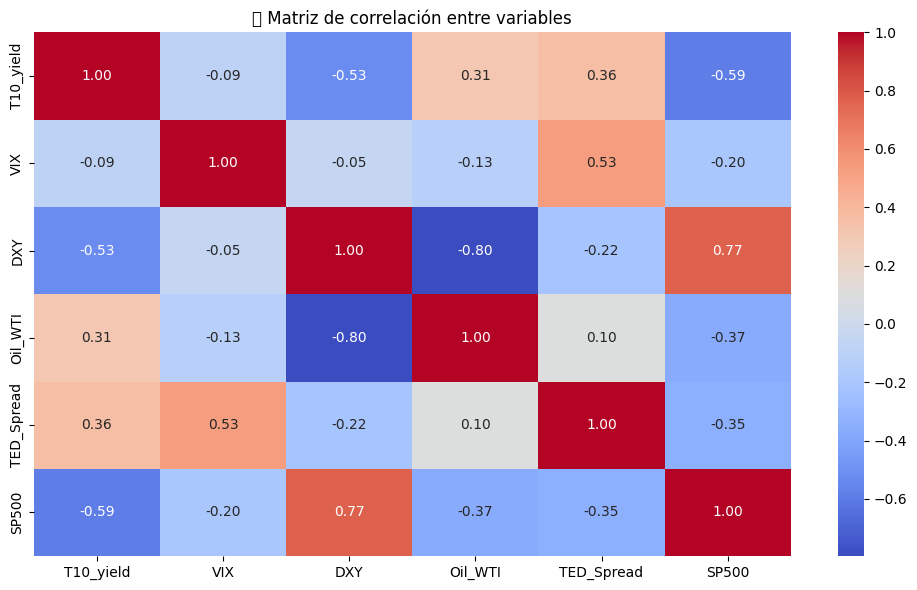

/tmp/ipykernel_33981/1715528445.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


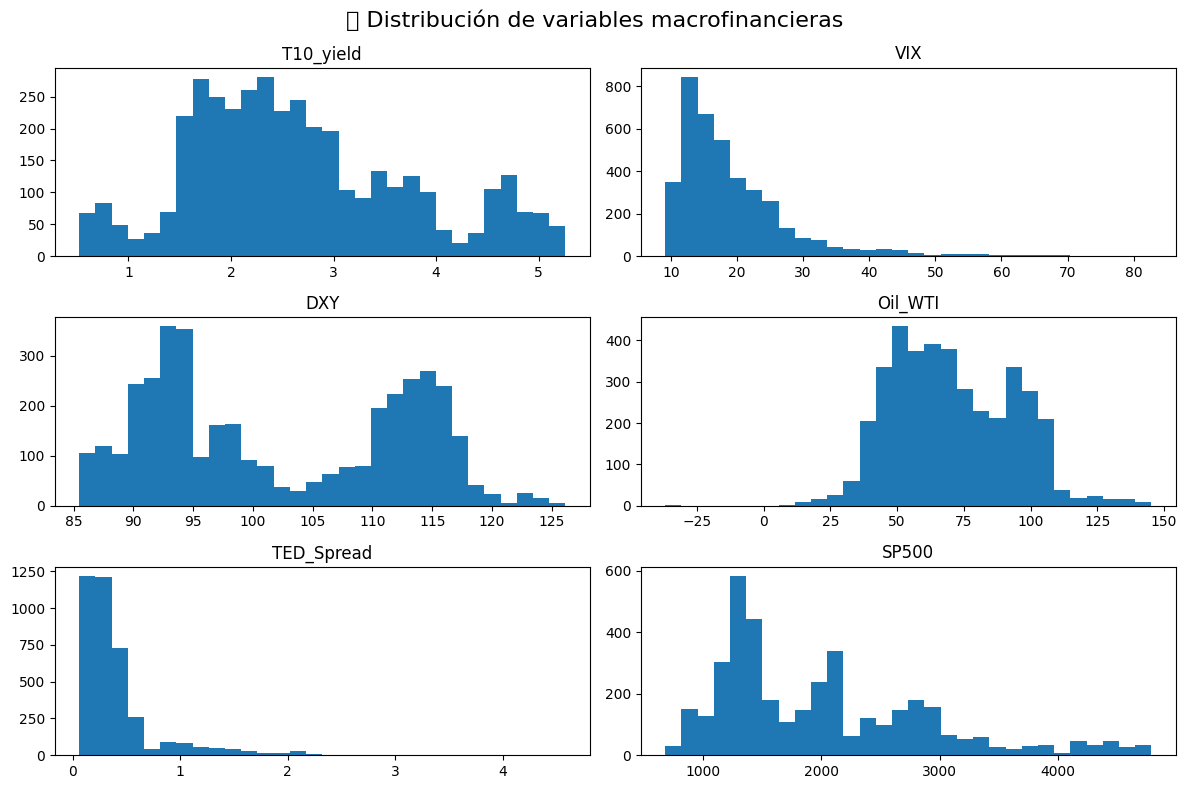

/tmp/ipykernel_33981/1715528445.py:39: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


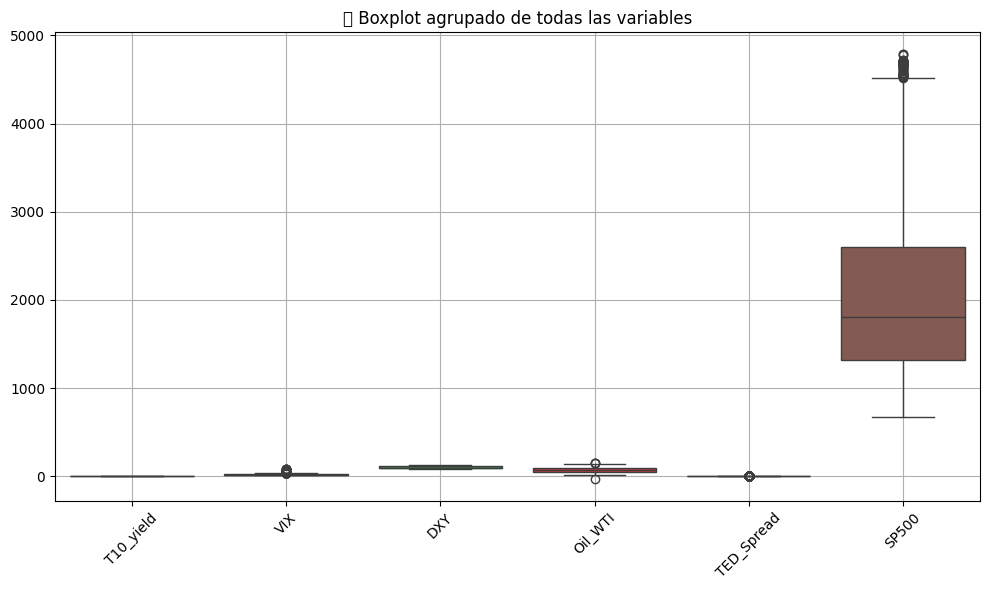

/tmp/ipykernel_33981/1715528445.py:44: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


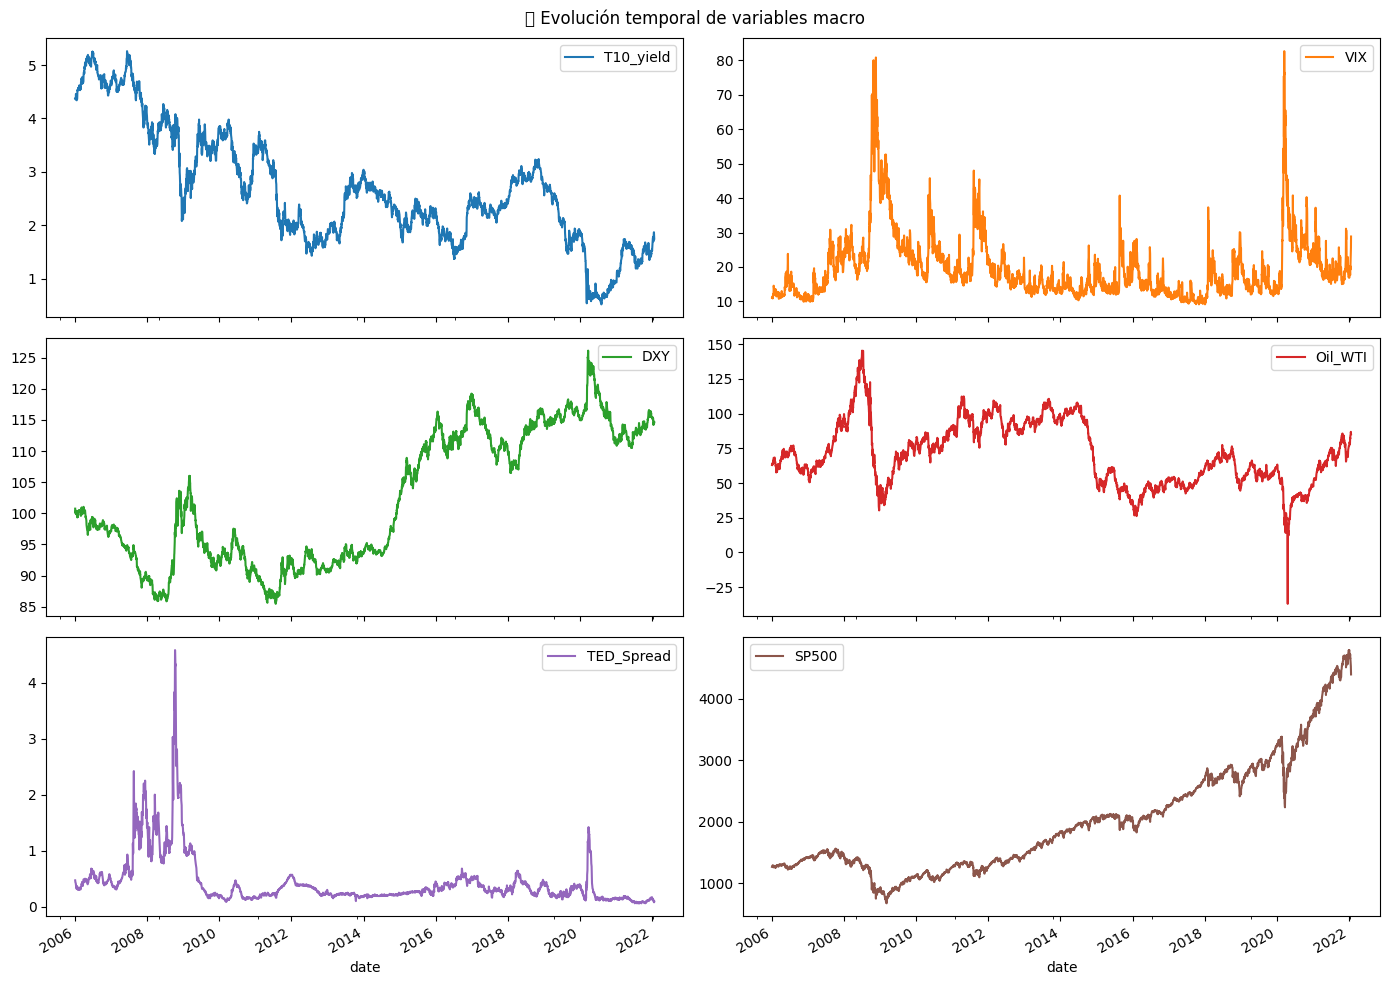

In [7]:
# ---------------------------------------------------------
# ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ---------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset consolidado y corregir índice temporal
df = pd.read_csv("sabana_macro_t10.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "date"}).set_index("date")

# 1. Estadísticos descriptivos
print("🔍 Resumen estadístico general:")
display(df.describe())

print("\n📋 Tipos de datos:")
print(df.dtypes)

# 2. Matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔗 Matriz de correlación entre variables")
plt.tight_layout()
plt.show()

# 3. Histogramas
df.hist(bins=30, figsize=(12, 8), grid=False)
plt.suptitle("📊 Distribución de variables macrofinancieras", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Boxplot agrupado
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title("🧭 Boxplot agrupado de todas las variables")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Series de tiempo por variable
df.plot(subplots=True, layout=(3, 2), figsize=(14, 10), title="📈 Evolución temporal de variables macro")
plt.tight_layout()
plt.show()

In [8]:
# ---------------------------------------------------------
# INSTALACIÓN DE DEPENDENCIAS REQUERIDAS
# ---------------------------------------------------------

# Esta celda instala automáticamente las librerías necesarias para ejecutar el análisis completo.
# Si ya están instaladas, este paso no genera conflictos.

import sys
!{sys.executable} -m pip install --quiet xgboost statsmodels seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_33981/1628463048.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(series.dropna(), nlags="auto")
/tmp/ipykernel_33981/1628463048.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(series.dropna(), nlags="auto")
/tmp/ipykernel_33981/1628463048.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(series.dropna(), nlags="auto")
/tmp/ipykernel_33981/1628463048.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the 

📊 Resultados de los tests de estacionariedad (ADF + KPSS):


/tmp/ipykernel_33981/1628463048.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(series.dropna(), nlags="auto")
/tmp/ipykernel_33981/1628463048.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_pval, *_ = kpss(series.dropna(), nlags="auto")


,ADF_p,ADF_result,KPSS_p,KPSS_result
T10_yield,0.3811,⚠️ No estacionaria,0.01,⚠️ No estacionaria
VIX,0.0,✅ Estacionaria,0.01,⚠️ No estacionaria
DXY,0.8232,⚠️ No estacionaria,0.01,⚠️ No estacionaria
Oil_WTI,0.2205,⚠️ No estacionaria,0.01,⚠️ No estacionaria
TED_Spread,0.0051,✅ Estacionaria,0.01,⚠️ No estacionaria
SP500,0.9982,⚠️ No estacionaria,0.01,⚠️ No estacionaria


/tmp/ipykernel_33981/1628463048.py:61: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


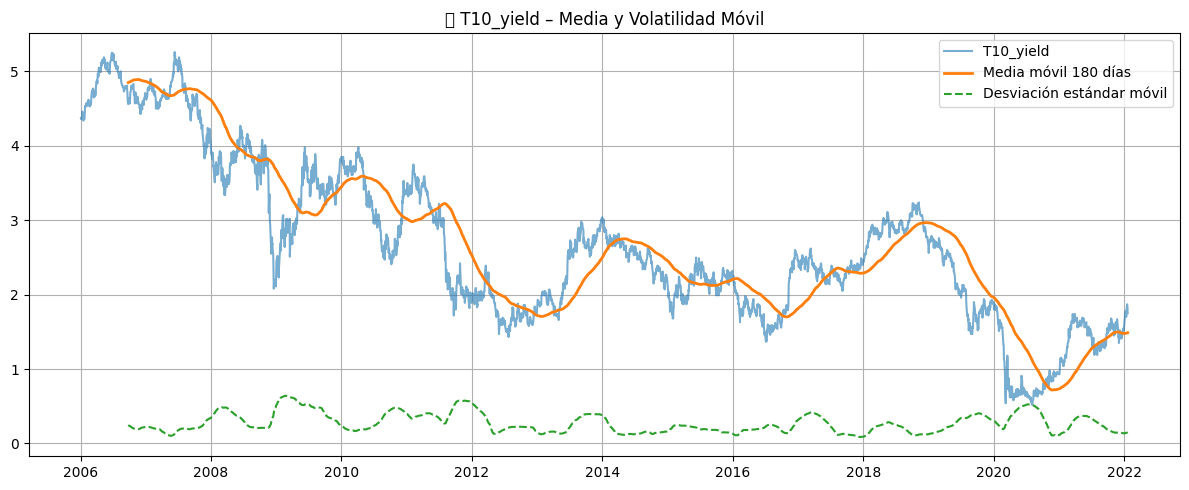

In [9]:
# ---------------------------------------------------------
# ANÁLISIS DE ESTACIONARIEDAD Y PROPIEDADES DINÁMICAS
# ---------------------------------------------------------

# Este bloque combina tests estadísticos de estacionariedad (ADF y KPSS) con el análisis visual
# de tendencias y volatilidad para cada variable macroeconómica, comenzando con 'T10_yield'.
# Esto permite evaluar tanto la validez de supuestos de modelos econométricos como patrones de comportamiento en el tiempo.

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

# Carga del dataset con fechas como índice
df = pd.read_csv("sabana_macro_t10.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "date"}).set_index("date")

# Selección de columnas numéricas
columns_to_test = df.select_dtypes(include="number").columns

# Función para aplicar ADF y KPSS con output interpretativo
def test_stationarity_mit_style(series):
    results = {}
    
    # ADF
    adf_stat, adf_pval, *_ = adfuller(series.dropna())
    results["ADF_p"] = round(adf_pval, 4)
    results["ADF_result"] = "✅ Estacionaria" if adf_pval < 0.05 else "⚠️ No estacionaria"
    
    # KPSS
    try:
        kpss_stat, kpss_pval, *_ = kpss(series.dropna(), nlags="auto")
        results["KPSS_p"] = round(kpss_pval, 4)
        results["KPSS_result"] = "⚠️ No estacionaria" if kpss_pval < 0.05 else "✅ Estacionaria"
    except:
        results["KPSS_p"] = None
        results["KPSS_result"] = "❌ Error en KPSS"
    
    return results

# Aplicar test a todas las series
stationarity_results_mit = pd.DataFrame({
    col: test_stationarity_mit_style(df[col])
    for col in columns_to_test
}).T

# Mostrar resultados
print("📊 Resultados de los tests de estacionariedad (ADF + KPSS):")
display(stationarity_results_mit)

# Análisis visual de propiedades dinámicas (ejemplo: T10_yield)
target_var = "T10_yield"
window = 180  # media móvil de aprox. 6 meses para frecuencia diaria

plt.figure(figsize=(12, 5))
plt.plot(df[target_var], label=f'{target_var}', alpha=0.6)
plt.plot(df[target_var].rolling(window).mean(), label=f'Media móvil {window} días', linewidth=2)
plt.plot(df[target_var].rolling(window).std(), label=f'Desviación estándar móvil', linestyle='--')
plt.title(f"📈 {target_var} – Media y Volatilidad Móvil")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# ---------------------------------------------------------
# TRANSFORMACIONES PARA ESTACIONARIEDAD
# ---------------------------------------------------------

# Este bloque aplica transformaciones a las variables no estacionarias identificadas previamente.
# Se prioriza la diferencia logarítmica para variables en niveles (precios, tasas, índices),
# y la diferencia simple para aquellas con posibles valores cero o negativos.

import numpy as np

# Copia del DataFrame original para transformar
df_transformed = pd.DataFrame(index=df.index)

for col in df.columns:
    serie = df[col]
    # Si la serie es estrictamente positiva, se aplica log-diff
    if (serie > 0).all():
        df_transformed[col + "_logdiff"] = np.log(serie).diff()
    else:
        # Si la serie tiene ceros o negativos, aplicar diferencia simple
        df_transformed[col + "_diff"] = serie.diff()

# Eliminar la primera fila con NaNs generados por la operación de diferencia
df_transformed = df_transformed.dropna()

# Vista previa del nuevo DataFrame transformado
print("Vista de las series transformadas:")
display(df_transformed.head())

# Guardar para uso en modelos
df_transformed.to_csv("sabana_transformada.csv")

print("✅ Dataset transformado y guardado como 'sabana_transformada.csv'")

Vista de las series transformadas:


,T10_yield_logdiff,VIX_logdiff,DXY_logdiff,Oil_WTI_diff,TED_Spread_logdiff,SP500_logdiff
date,,,,,,
2006-01-04,-0.002291,0.020436,-0.005244,0.30,-0.043485,0.003666
2006-01-05,0.000000,-0.005291,0.000702,-0.60,0.000000,0.000016
2006-01-06,0.004577,-0.027792,-0.002747,1.40,-0.045462,0.009356
2006-01-09,0.000000,0.011749,0.001551,-0.65,-0.023530,0.003650
2006-01-10,0.011351,-0.024558,-0.000357,-0.15,-0.100083,-0.000357


✅ Dataset transformado y guardado como 'sabana_transformada.csv'


In [11]:
# ---------------------------------------------------------
# VALIDACIÓN POST-TRANSFORMACIÓN Y DICCIONARIO DE VARIABLES
# ---------------------------------------------------------

# Instalación de dependencias (si no están instaladas)
# !pip install statsmodels

import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# Cargar el dataset transformado
df_transformed = pd.read_csv("sabana_transformada.csv", parse_dates=["date"], index_col="date")

# Función combinada: test ADF y KPSS con interpretación robusta
def test_stationarity_summary(series):
    adf_stat, adf_p, _, _, _, _ = adfuller(series, autolag="AIC")
    try:
        kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags="auto")
    except:
        kpss_stat, kpss_p = None, None

    # Diagnóstico final combinando criterios
    if adf_p < 0.05 and (kpss_p is None or kpss_p > 0.05):
        status = "✅ Estacionaria"
    elif adf_p < 0.05 and kpss_p < 0.05:
        status = "⚠️ Conflicto ADF/KPSS"
    elif adf_p > 0.05 and kpss_p < 0.05:
        status = "❌ No estacionaria"
    else:
        status = "⚠️ Inconcluso"

    return {
        "ADF p-value": round(adf_p, 4),
        "KPSS p-value": round(kpss_p, 4) if kpss_p is not None else "n/a",
        "Resultado": status
    }

# Evaluación para cada columna
df_validation = pd.DataFrame({col: test_stationarity_summary(df_transformed[col]) for col in df_transformed.columns}).T

# Diccionario de transformaciones aplicadas
dict_transformaciones = []
for col in df_transformed.columns:
    original = col.replace("_logdiff", "").replace("_diff", "")
    tipo = "Diferencia logarítmica" if "_logdiff" in col else "Diferencia simple"
    justificacion = ("Serie en niveles positivos, se modela crecimiento porcentual" 
                     if "_logdiff" in col else 
                     "Serie incluye ceros/negativos, log no aplicable")
    dict_transformaciones.append({
        "Variable original": original,
        "Variable transformada": col,
        "Tipo de transformación": tipo,
        "Justificación": justificacion
    })

df_diccionario = pd.DataFrame(dict_transformaciones)

/tmp/ipykernel_33981/1884441679.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags="auto")
/tmp/ipykernel_33981/1884441679.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags="auto")
/tmp/ipykernel_33981/1884441679.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags="auto")
/tmp/ipykernel_33981/1884441679.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is

In [12]:
# ---------------------------------------------------------
# CONSTRUCCIÓN DEL SET DE ENTRENAMIENTO SUPERVISADO
# ---------------------------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar la sabana transformada
df = pd.read_csv("sabana_transformada.csv", parse_dates=["date"], index_col="date")

# Variable objetivo: rendimiento del Treasury a 10 años (transformado)
y = df["T10_yield_logdiff"].copy()

# Variables explicativas: todas menos la variable objetivo
X = df.drop(columns=["T10_yield_logdiff"])

# División en set de entrenamiento y prueba (80% / 20%) con respeto al orden temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Confirmación de dimensiones
print(f"✅ X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"✅ y_train: {y_train.shape}, y_test: {y_test.shape}")

✅ X_train: (3121, 5), X_test: (781, 5)
✅ y_train: (3121,), y_test: (781,)


In [13]:
# ---------------------------------------------------------
# GENERACIÓN DE VARIABLES LAG (1 A 5 DÍAS)
# ---------------------------------------------------------

import pandas as pd

# Cargar la sabana transformada
df = pd.read_csv("sabana_transformada.csv", parse_dates=["date"], index_col="date")

# Crear lags de 1 a 5 días para cada variable
lags = [1, 2, 3, 4, 5]
df_lags = df.copy()

for col in df.columns:
    for lag in lags:
        df_lags[f"{col}_lag{lag}"] = df[col].shift(lag)

# Eliminar filas con valores nulos generados por el shift
df_lags = df_lags.dropna()

# Verificación rápida
print("\n✅ Dataset con lags generado exitosamente:")
display(df_lags.head())

# Exportación del dataset extendido
df_lags.to_csv("sabana_transformada_lags.csv")


✅ Dataset con lags generado exitosamente:


,T10_yield_logdiff,VIX_logdiff,DXY_logdiff,Oil_WTI_diff,TED_Spread_logdiff,SP500_logdiff,T10_yield_logdiff_lag1,T10_yield_logdiff_lag2,T10_yield_logdiff_lag3,T10_yield_logdiff_lag4,...,TED_Spread_logdiff_lag1,TED_Spread_logdiff_lag2,TED_Spread_logdiff_lag3,TED_Spread_logdiff_lag4,TED_Spread_logdiff_lag5,SP500_logdiff_lag1,SP500_logdiff_lag2,SP500_logdiff_lag3,SP500_logdiff_lag4,SP500_logdiff_lag5
date,,,,,,,,,,,,,,,,,,,,,
2006-01-11,0.006749,0.007339,-0.002726,0.50,0.000000,0.003475,0.011351,0.000000,0.004577,0.000000,...,-0.100083,-0.023530,-0.045462,0.000000,-0.043485,-0.000357,0.003650,0.009356,0.000016,0.003666
2006-01-12,-0.009009,0.023488,0.001934,0.05,0.000000,-0.006294,0.006749,0.011351,0.000000,0.004577,...,0.000000,-0.100083,-0.023530,-0.045462,0.000000,0.003475,-0.000357,0.003650,0.009356,0.000016
2006-01-13,-0.013668,0.002675,-0.000968,-0.10,-0.026668,0.001204,-0.009009,0.006749,0.011351,0.000000,...,0.000000,0.000000,-0.100083,-0.023530,-0.045462,-0.006294,0.003475,-0.000357,0.003650,0.009356
2006-01-17,-0.004598,0.058790,0.002769,2.50,-0.145182,-0.003641,-0.013668,-0.009009,0.006749,0.011351,...,-0.026668,0.000000,0.000000,-0.100083,-0.023530,0.001204,-0.006294,0.003475,-0.000357,0.003650
2006-01-18,0.000000,0.028148,0.001633,-0.60,0.089612,-0.003905,-0.004598,-0.013668,-0.009009,0.006749,...,-0.145182,-0.026668,0.000000,0.000000,-0.100083,-0.003641,0.001204,-0.006294,0.003475,-0.000357


In [14]:
# ---------------------------------------------------------
# CONSTRUCCIÓN DEL SET DE ENTRENAMIENTO SUPERVISADO
# ---------------------------------------------------------

import pandas as pd

# Cargar el dataset con lags ya generados
df_lags = pd.read_csv("sabana_transformada_lags.csv", parse_dates=["date"], index_col="date")

# Definir variable objetivo: crecimiento (log-diff) del rendimiento T10
target_variable = "T10_yield_logdiff"

# Separación de X (features) e y (target)
y = df_lags[target_variable]
X = df_lags.drop(columns=[target_variable])

# Validación
print(f"\n✅ Variable objetivo definida: {target_variable}")
print(f"Dimensiones X: {X.shape}, y: {y.shape}")
print(f"Rango temporal: {X.index.min().date()} → {X.index.max().date()}")


✅ Variable objetivo definida: T10_yield_logdiff
Dimensiones X: (3897, 35), y: (3897,)
Rango temporal: 2006-01-11 → 2022-01-21


In [15]:
# ---------------------------------------------------------
# FEATURES DE ESTADÍSTICAS MÓVILES: ROLLING MEAN Y STD
# ---------------------------------------------------------

# Copia base del set con lags
df_rolling = df_lags.copy()

# Generar media y desviación estándar móvil para ventanas de 20 y 60 días
for col in df_rolling.columns:
    df_rolling[f"{col}_rollmean20"] = df_rolling[col].rolling(window=20).mean()
    df_rolling[f"{col}_rollstd20"] = df_rolling[col].rolling(window=20).std()
    df_rolling[f"{col}_rollmean60"] = df_rolling[col].rolling(window=60).mean()
    df_rolling[f"{col}_rollstd60"] = df_rolling[col].rolling(window=60).std()

# Drop de filas con nulos introducidos por el rolling
df_rolling.dropna(inplace=True)

# Exportar versión enriquecida con estadísticas móviles
df_rolling.to_csv("sabana_transformada_lags_rolling.csv", index=True)

print(f"✅ Dataset final con estadísticas móviles generado exitosamente")
print(f"Dimensiones: {df_rolling.shape}")
print(f"Rango temporal: {df_rolling.index.min().date()} → {df_rolling.index.max().date()}")

/tmp/ipykernel_33981/2917082827.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_rolling[f"{col}_rollstd60"] = df_rolling[col].rolling(window=60).std()
/tmp/ipykernel_33981/2917082827.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_rolling[f"{col}_rollmean20"] = df_rolling[col].rolling(window=20).mean()
/tmp/ipykernel_33981/2917082827.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

✅ Dataset final con estadísticas móviles generado exitosamente
Dimensiones: (3838, 180)
Rango temporal: 2006-04-06 → 2022-01-21


In [18]:
# ---------------------------------------------------------
# GENERACIÓN DE VARIABLES DE INTERACCIÓN ECONÓMICA
# ---------------------------------------------------------

# Carga robusta del dataset final con lags y estadísticas móviles
import pandas as pd

df_interact = pd.read_csv("sabana_transformada_lags_rolling.csv")

# Ajuste del índice temporal
if "date" in df_interact.columns:
    df_interact["date"] = pd.to_datetime(df_interact["date"])
    df_interact.set_index("date", inplace=True)
elif "Unnamed: 0" in df_interact.columns:
    df_interact.rename(columns={"Unnamed: 0": "date"}, inplace=True)
    df_interact["date"] = pd.to_datetime(df_interact["date"])
    df_interact.set_index("date", inplace=True)
else:
    raise ValueError("⚠️ No se encontró una columna de fecha para parsear.")

# Interacciones económicas corregidas (según columnas existentes)
df_interact["Oil_x_DXY"] = df_interact["Oil_WTI_diff"] * df_interact["DXY_logdiff"]
df_interact["VIX_x_SP500_lag1"] = df_interact["VIX_logdiff"] * df_interact["SP500_logdiff_lag1"]
df_interact["TED_x_T10_lag2"] = df_interact["TED_Spread_logdiff"] * df_interact["T10_yield_logdiff_lag2"]
df_interact["VIX_diff_x_DXY_lag1"] = df_interact["VIX_logdiff"] * df_interact["DXY_logdiff_lag1"]

# Eliminación de nulos y exportación
df_interact.dropna(inplace=True)
df_interact.to_csv("sabana_final_modelado.csv", index=True)

print("✅ Dataset final con interacciones económicas exportado como 'sabana_final_modelado.csv'")
print(f"Dimensiones finales: {df_interact.shape}")

✅ Dataset final con interacciones económicas exportado como 'sabana_final_modelado.csv'
Dimensiones finales: (3838, 184)


/tmp/ipykernel_33981/3455998208.py:28: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


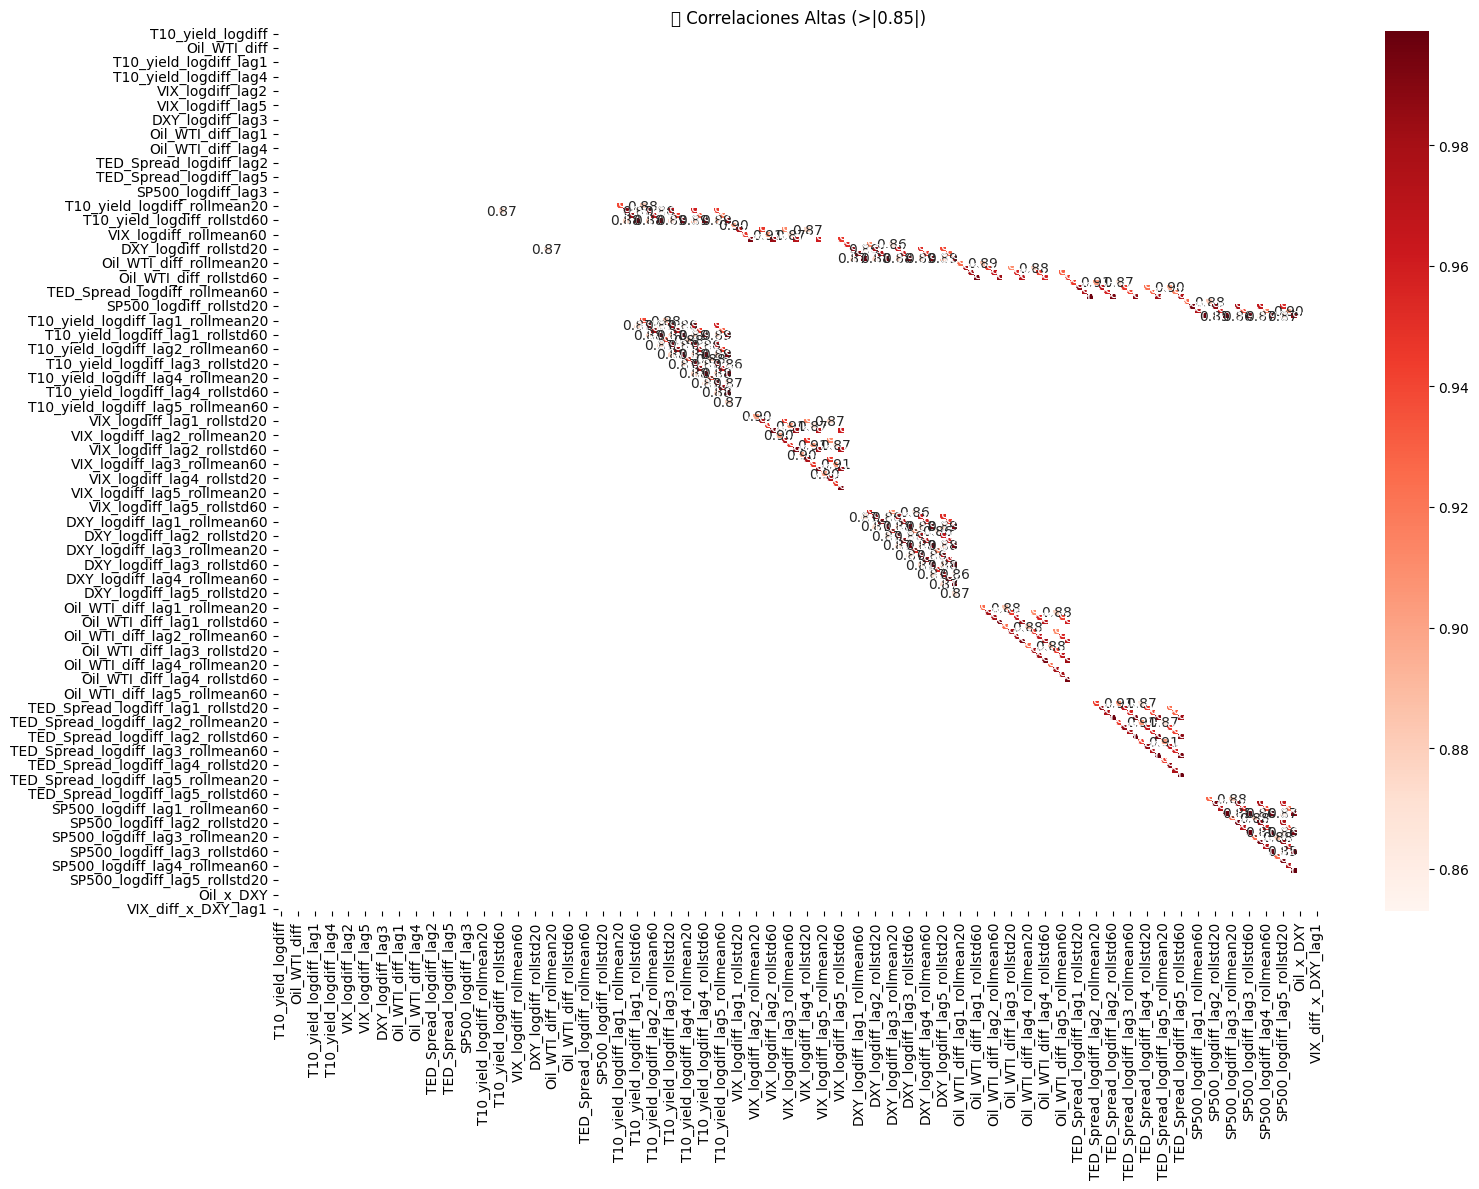

,Variable,VIF
5,SP500_logdiff,2.505417
1,VIX_logdiff,2.192724
23,Oil_WTI_diff_lag3,1.286188
22,Oil_WTI_diff_lag2,1.284734
24,Oil_WTI_diff_lag4,1.276575
21,Oil_WTI_diff_lag1,1.274267
0,T10_yield_logdiff,1.244110
13,VIX_logdiff_lag3,1.238479
12,VIX_logdiff_lag2,1.236111
14,VIX_logdiff_lag4,1.231349


In [19]:
# ---------------------------------------------------------
# ANÁLISIS DE MULTICOLINEALIDAD – HEATMAP Y VIF
# ---------------------------------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Carga del dataset final con todas las transformaciones
df = pd.read_csv("sabana_final_modelado.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# 1. HEATMAP DE CORRELACIONES ALTAS
# ----------------------------------
# Subset solo con variables numéricas
df_num = df.select_dtypes(include=["float64", "int64"])

# Matriz de correlaciones
corr_matrix = df_num.corr().abs()

# Filtro: solo correlaciones > 0.85 (excepto diagonal)
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
plt.figure(figsize=(16, 12))
sns.heatmap(high_corr[(high_corr > 0.85)], cmap="Reds", annot=True, fmt=".2f")
plt.title("🔍 Correlaciones Altas (>|0.85|)")
plt.tight_layout()
plt.show()

# 2. VARIANCE INFLATION FACTOR (VIF)
# ----------------------------------
# Seleccionamos un subconjunto de variables para ilustración (por tiempo)
subset_cols = df_num.columns[:30]  # puedes ajustar a más si tienes recursos
X_scaled = StandardScaler().fit_transform(df_num[subset_cols])

# Cálculo del VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = subset_cols
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Ordenamos por VIF descendente
vif_data = vif_data.sort_values(by="VIF", ascending=False)
display(vif_data)

In [20]:
# ---------------------------------------------------------
# ANÁLISIS DE MULTICOLINEALIDAD – CLASIFICACIÓN DE VARIABLES
# ---------------------------------------------------------

import pandas as pd

# Cargar el dataset final
df = pd.read_csv("sabana_final_modelado.csv", parse_dates=["date"], index_col="date")

# Clasificación de columnas según tipo
cols_originales = [c for c in df.columns if "_lag" not in c and "_roll" not in c and "_x_" not in c]
cols_lags = [c for c in df.columns if "_lag" in c and "_roll" not in c]
cols_rolling = [c for c in df.columns if "_roll" in c]
cols_interaccion = [c for c in df.columns if "_x_" in c]

# Mostrar resumen de cada categoría
print("📌 Total variables:", df.shape[1])
print("• Originales:", len(cols_originales))
print("• Lags:", len(cols_lags))
print("• Rolling:", len(cols_rolling))
print("• Interacción:", len(cols_interaccion))

📌 Total variables: 184
• Originales: 6
• Lags: 33
• Rolling: 144
• Interacción: 4


/tmp/ipykernel_33981/2860931300.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


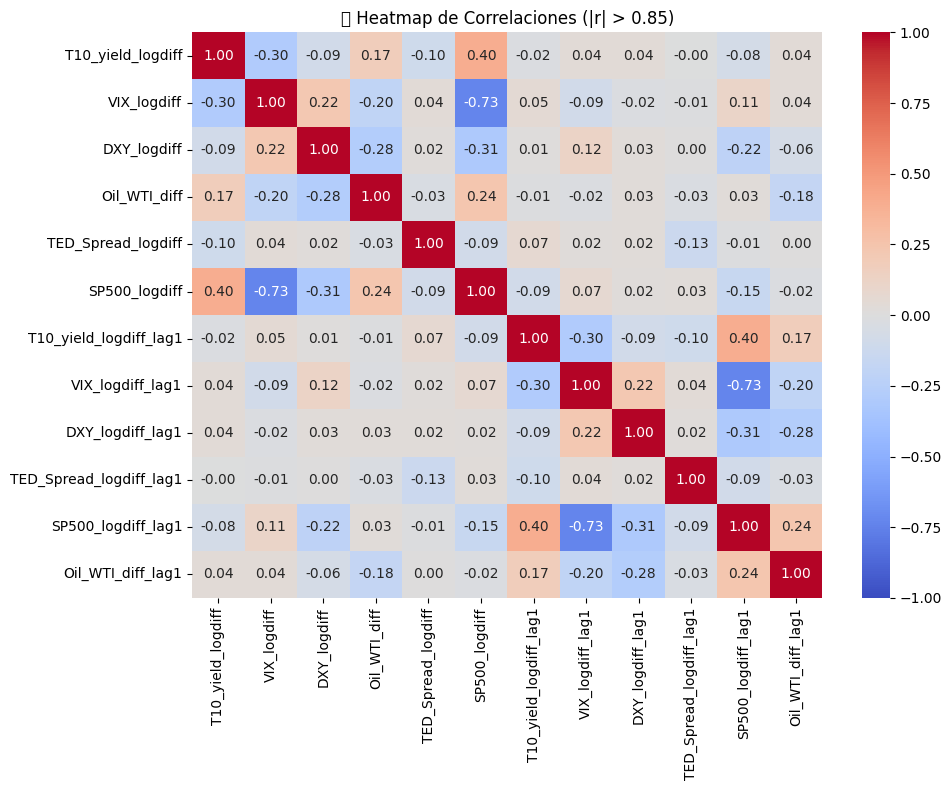

📈 Variance Inflation Factor (VIF):


,Variable,VIF
10,SP500_logdiff_lag1,2.712690
5,SP500_logdiff,2.553486
7,VIX_logdiff_lag1,2.173956
1,VIX_logdiff,2.152333
2,DXY_logdiff,1.304413
6,T10_yield_logdiff_lag1,1.230934
0,T10_yield_logdiff,1.218105
11,Oil_WTI_diff_lag1,1.189274
3,Oil_WTI_diff,1.184592
8,DXY_logdiff_lag1,1.179243


In [21]:
# ---------------------------------------------------------
# ANÁLISIS DE MULTICOLINEALIDAD – HEATMAP Y VIF
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Cargar dataset final
df = pd.read_csv("sabana_final_modelado.csv", parse_dates=["date"], index_col="date")

# Seleccionar un subconjunto representativo para análisis VIF (sin colinealidad excesiva por rolling/lags)
vars_vif = [
    "T10_yield_logdiff", "VIX_logdiff", "DXY_logdiff", "Oil_WTI_diff",
    "TED_Spread_logdiff", "SP500_logdiff",
    "T10_yield_logdiff_lag1", "VIX_logdiff_lag1", "DXY_logdiff_lag1",
    "TED_Spread_logdiff_lag1", "SP500_logdiff_lag1", "Oil_WTI_diff_lag1"
]

# 1. HEATMAP DE CORRELACIONES ALTAS
corr = df[vars_vif].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", center=0, vmin=-1, vmax=1)
plt.title("📊 Heatmap de Correlaciones (|r| > 0.85)")
plt.tight_layout()
plt.show()

# 2. CÁLCULO DEL VIF
X_vif = StandardScaler().fit_transform(df[vars_vif].dropna())
vif_df = pd.DataFrame({
    "Variable": vars_vif,
    "VIF": [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
})
print("📈 Variance Inflation Factor (VIF):")
display(vif_df.sort_values("VIF", ascending=False))

In [22]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [23]:
# ---------------------------------------------------------
# SELECCIÓN AUTOMÁTICA DE VARIABLES – LASSO
# ---------------------------------------------------------

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Cargar el dataset final
df = pd.read_csv("sabana_final_modelado.csv", parse_dates=["date"]).set_index("date")

# Definir variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Estandarizar los predictores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso con validación cruzada
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

# Coeficientes seleccionados
coef = pd.Series(lasso.coef_, index=X.columns)
selected_features = coef[coef != 0].index.tolist()

print(f"✅ Variables seleccionadas por Lasso: {len(selected_features)}")
print(selected_features)

# Guardar subconjunto reducido
df_lasso = df[["T10_yield_logdiff"] + selected_features]
df_lasso.to_csv("sabana_lasso_selected.csv")

✅ Variables seleccionadas por Lasso: 113
['VIX_logdiff', 'DXY_logdiff', 'Oil_WTI_diff', 'TED_Spread_logdiff', 'SP500_logdiff', 'T10_yield_logdiff_lag1', 'T10_yield_logdiff_lag2', 'T10_yield_logdiff_lag3', 'T10_yield_logdiff_lag4', 'T10_yield_logdiff_lag5', 'VIX_logdiff_lag1', 'VIX_logdiff_lag2', 'VIX_logdiff_lag3', 'VIX_logdiff_lag4', 'DXY_logdiff_lag1', 'DXY_logdiff_lag2', 'DXY_logdiff_lag3', 'Oil_WTI_diff_lag1', 'Oil_WTI_diff_lag2', 'Oil_WTI_diff_lag3', 'Oil_WTI_diff_lag4', 'Oil_WTI_diff_lag5', 'TED_Spread_logdiff_lag1', 'TED_Spread_logdiff_lag3', 'TED_Spread_logdiff_lag4', 'TED_Spread_logdiff_lag5', 'SP500_logdiff_lag1', 'SP500_logdiff_lag2', 'SP500_logdiff_lag3', 'SP500_logdiff_lag4', 'SP500_logdiff_lag5', 'T10_yield_logdiff_rollmean20', 'T10_yield_logdiff_rollstd20', 'T10_yield_logdiff_rollmean60', 'T10_yield_logdiff_rollstd60', 'VIX_logdiff_rollmean20', 'VIX_logdiff_rollstd20', 'VIX_logdiff_rollmean60', 'DXY_logdiff_rollmean20', 'DXY_logdiff_rollmean60', 'Oil_WTI_diff_rollmean20'

In [ ]:
# ---------------------------------------------------------
# SELECCIÓN DE VARIABLES – RFE CON RANDOM FOREST
# ---------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Cargar el dataset reducido por Lasso
df = pd.read_csv("sabana_lasso_selected.csv", parse_dates=["date"]).set_index("date")

# Variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Modelo base: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Validación cruzada por bloques temporales
tscv = TimeSeriesSplit(n_splits=5)

# RFE con 20 variables (puedes ajustar según tamaño de X)
rfe = RFE(estimator=rf, n_features_to_select=20, step=1)
rfe.fit(X, y)

# Variables seleccionadas
selected_rfe = X.columns[rfe.support_].tolist()
print(f"✅ Variables seleccionadas por RFE: {len(selected_rfe)}")
print(selected_rfe)

# Exportar dataset con variables RFE
df_rfe = df[["T10_yield_logdiff"] + selected_rfe]
df_rfe.to_csv("sabana_rfe_selected.csv")

In [1]:
# ---------------------------------------------------------
# SELECCIÓN DE VARIABLES – RFE CON RANDOM FOREST (OPTIMIZADO)
# ---------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Cargar el dataset reducido por Lasso
df = pd.read_csv("sabana_lasso_selected.csv", parse_dates=["date"]).set_index("date")

# Variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Modelo base: Random Forest más liviano
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# RFE con reducción acelerada
rfe = RFE(estimator=rf, n_features_to_select=20, step=5)
rfe.fit(X, y)

# Variables seleccionadas
selected_rfe = X.columns[rfe.support_].tolist()
print(f"✅ Variables seleccionadas por RFE: {len(selected_rfe)}")
print(selected_rfe)

# Exportar dataset final
df_rfe = df[["T10_yield_logdiff"] + selected_rfe]
df_rfe.to_csv("sabana_rfe_selected.csv")

✅ Variables seleccionadas por RFE: 20
['DXY_logdiff', 'Oil_WTI_diff', 'SP500_logdiff', 'T10_yield_logdiff_lag1', 'T10_yield_logdiff_lag2', 'T10_yield_logdiff_lag3', 'T10_yield_logdiff_lag4', 'T10_yield_logdiff_lag5', 'TED_Spread_logdiff_lag5', 'T10_yield_logdiff_rollmean20', 'T10_yield_logdiff_rollstd20', 'T10_yield_logdiff_rollmean60', 'T10_yield_logdiff_rollstd60', 'VIX_logdiff_rollmean20', 'TED_Spread_logdiff_rollstd20', 'T10_yield_logdiff_lag1_rollmean20', 'T10_yield_logdiff_lag2_rollmean20', 'T10_yield_logdiff_lag3_rollmean20', 'TED_Spread_logdiff_lag2_rollstd60', 'VIX_x_SP500_lag1']


In [2]:
# ---------------------------------------------------------
# DEFINICIÓN FINAL DEL DATASET Y DIVISIÓN TEMPORAL
# ---------------------------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar dataset con las 20 variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Separar variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# División temporal: 80% train / 20% test (sin shuffle)
split_point = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Verificación de dimensiones
print("✅ Dataset estructurado para modelamiento temporal.")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

✅ Dataset estructurado para modelamiento temporal.
Train: (3070, 20), Test: (768, 20)


In [3]:
# ---------------------------------------------------------
# INSTALACIÓN DE XGBOOST (solo si no está previamente instalado)
# ---------------------------------------------------------

try:
    from xgboost import XGBRegressor
except ImportError:
    import sys
    !{sys.executable} -m pip install xgboost

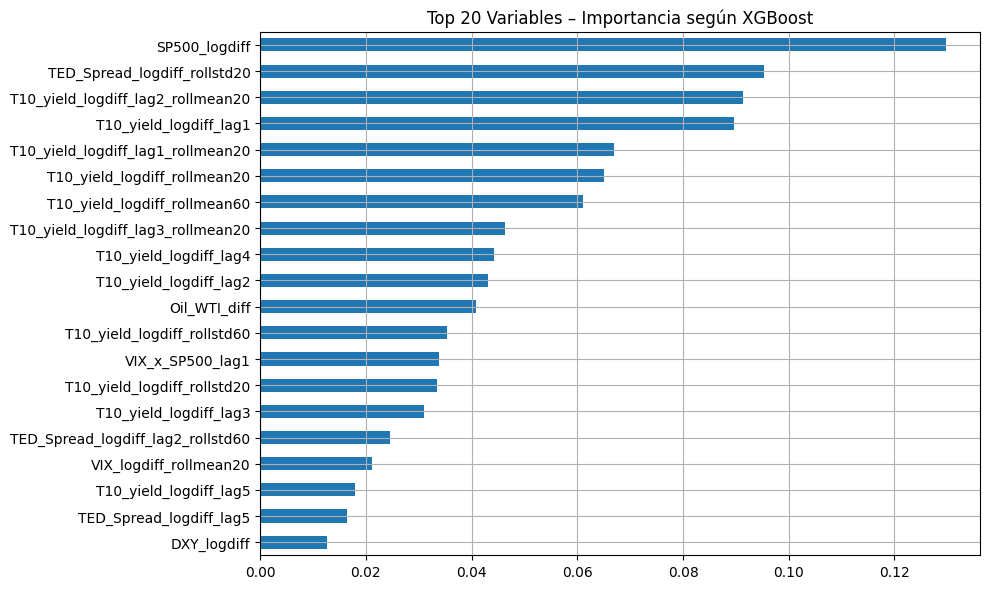

In [4]:
# ---------------------------------------------------------
# VALIDACIÓN DE VARIABLES – FEATURE IMPORTANCE CON XGBOOST
# ---------------------------------------------------------

# Instalar XGBoost si no está disponible
# !pip install xgboost

from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset reducido por RFE (puedes cambiar a Lasso si lo prefieres)
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Definir variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Entrenamiento del modelo XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X, y)

# Obtener importancia de variables
importancia = pd.Series(xgb_model.feature_importances_, index=X.columns)
importancia = importancia.sort_values(ascending=False)

# Visualización de las 20 principales
plt.figure(figsize=(10, 6))
importancia.head(20).plot(kind="barh")
plt.title("Top 20 Variables – Importancia según XGBoost")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exportar ranking completo
importancia.to_csv("xgboost_feature_importance.csv")

In [6]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 58.0 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ SHAP values calculados y visualizados. Exportados como 'shap_summary_bar.png' y 'shap_summary_dot.png'


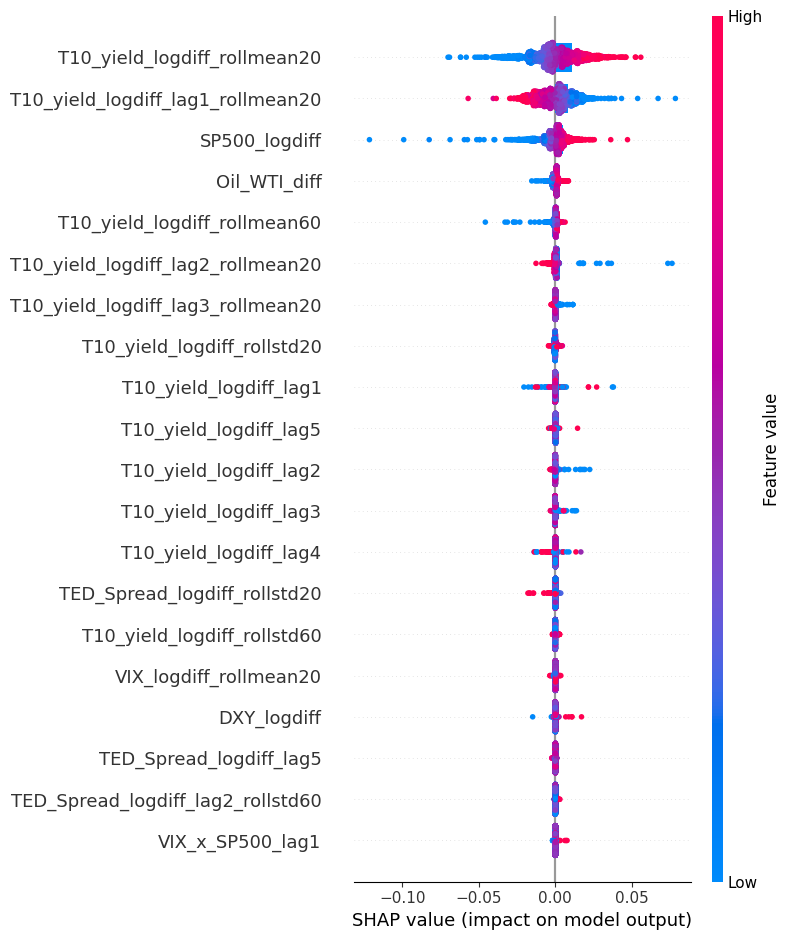

In [7]:
# ---------------------------------------------------------
# INTERPRETABILIDAD – SHAP VALUES CON XGBOOST
# ---------------------------------------------------------

# Para entender la contribución individual de cada predictor al modelo, se calcularon SHAP values.
# Esta técnica basada en teoría de juegos cuantifica el aporte marginal de cada variable a cada predicción.

# Se utilizó un modelo XGBoost entrenado previamente con las 20 variables seleccionadas por RFE,
# y se aplicó TreeExplainer, óptimo para modelos basados en árboles.

# El resultado incluye dos visualizaciones:
# - Un gráfico de barras con las variables más influyentes.
# - Un gráfico de dispersión con la distribución de impacto por observación.

from xgboost import XGBRegressor
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Entrenar modelo
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X, y)

# SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Visualización: Gráfico de barras
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar.png")

# Visualización: Dispersión
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("shap_summary_dot.png")

print("✅ SHAP values calculados y visualizados. Exportados como 'shap_summary_bar.png' y 'shap_summary_dot.png'")

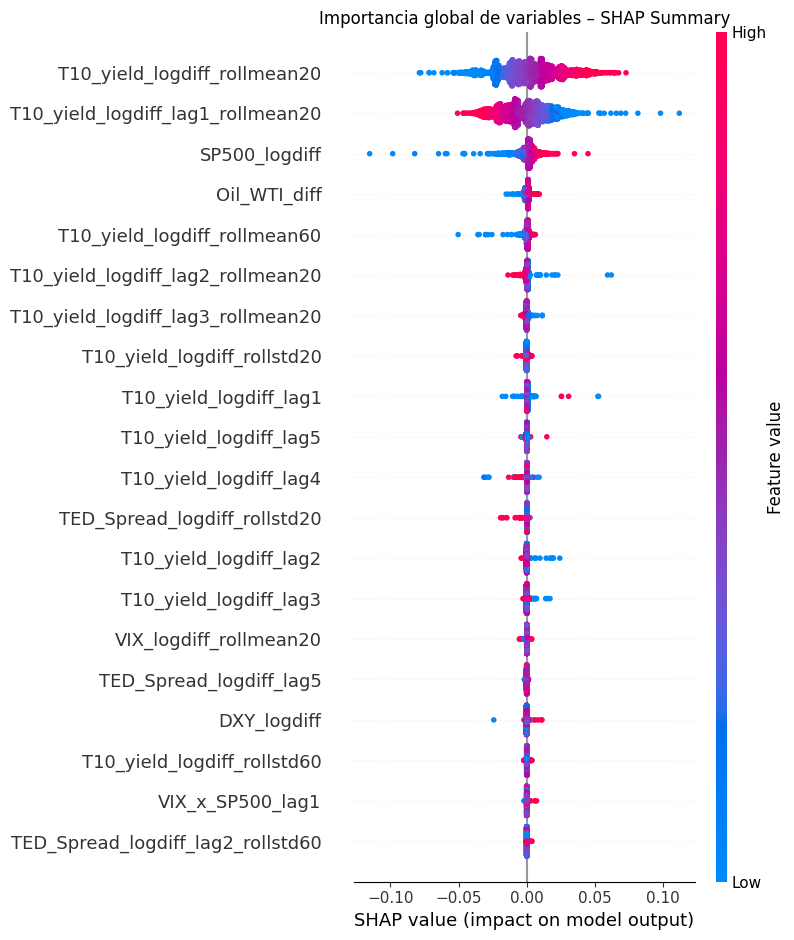

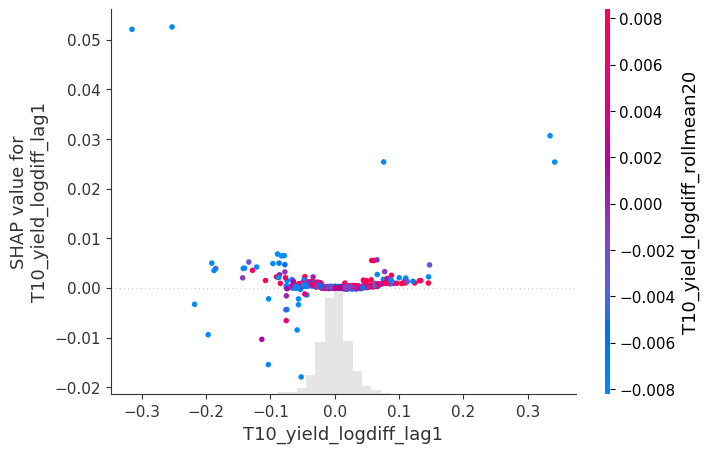

In [9]:
# ---------------------------------------------------------
# INTERPRETABILIDAD DE MODELO – SHAP CON XGBOOST
# ---------------------------------------------------------

# Antes de correr este bloque, asegúrate de tener instalada la librería SHAP:
# !pip install shap

import shap
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Entrenar modelo XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb_model.fit(X, y)

# Inicializar el explicador SHAP para el modelo XGBoost
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

# -----------------------
# 📊 Gráfico summary plot
# -----------------------
plt.title("Importancia global de variables – SHAP Summary")
shap.summary_plot(shap_values, X, show=True)

# -------------------------------
# 📈 Gráfico de dependencia (ejemplo)
# -------------------------------
# Elige una variable relevante (ajusta según tus resultados)
var_destacada = "T10_yield_logdiff_lag1"
shap.plots.scatter(shap_values[:, var_destacada], color=shap_values)

In [10]:
# ---------------------------------------------------------
# MODELADO PREDICTIVO – BENCHMARK Y MODELOS AVANZADOS
# ---------------------------------------------------------

# 🔹 MÓDULO 1: REGRESIÓN LINEAL (OLS) COMO BENCHMARK

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Cargar dataset final con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Variable dependiente y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Validación temporal con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mae_list, rmse_list, r2_list = [], [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))

# Resultados promedio del benchmark OLS
print("\n\u2705 Resultados del modelo OLS (Benchmark):")
print(f"MAE promedio: {np.mean(mae_list):.6f}")
print(f"RMSE promedio: {np.mean(rmse_list):.6f}")
print(f"R^2 promedio: {np.mean(r2_list):.6f}")


✅ Resultados del modelo OLS (Benchmark):
MAE promedio: 0.013580
RMSE promedio: 0.018766
R^2 promedio: 0.542910


📊 Entrenamiento – MAE: 0.00715, RMSE: 0.00928, R²: 0.81616
📊 Test – MAE: 0.02261, RMSE: 0.03943, R²: 0.21907


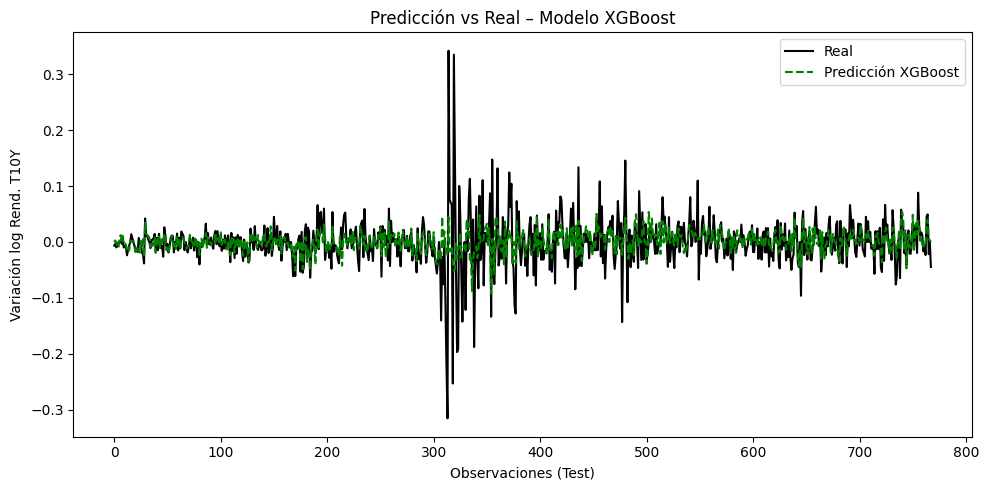

In [12]:
# ---------------------------------------------------------
# MODELADO – XGBOOST CON TUNING Y MÉTRICAS EXTENDIDAS
# ---------------------------------------------------------

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Definir variable objetivo y predictores
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# Separación temporal: 80% entrenamiento, 20% test
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Modelo XGBoost con tuning moderado
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Función de evaluación (corregida)
def evaluar(y_true, y_pred, nombre_conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5  # 👈 aquí la corrección
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {nombre_conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")
    return mae, rmse, r2

# Evaluación
_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Gráfico de comparación
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Real", color="black")
plt.plot(y_pred_test, label="Predicción XGBoost", color="green", linestyle="--")
plt.title("Predicción vs Real – Modelo XGBoost")
plt.xlabel("Observaciones (Test)")
plt.ylabel("Variación log Rend. T10Y")
plt.legend()
plt.tight_layout()
plt.savefig("xgboost_pred_vs_real.png", dpi=300)
plt.show()

📋 Classification Report
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       442
           1       0.68      0.73      0.71       326

    accuracy                           0.74       768
   macro avg       0.73      0.74      0.74       768
weighted avg       0.74      0.74      0.74       768

🔎 Confusion Matrix
[[329 113]
 [ 87 239]]


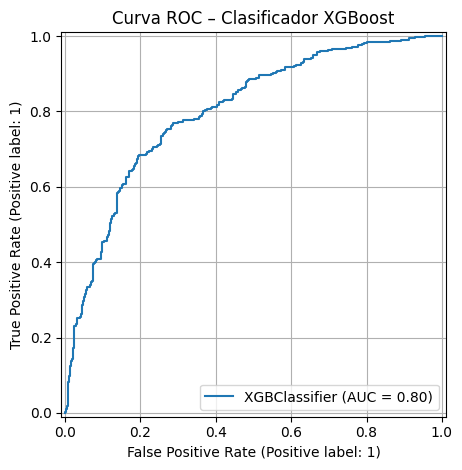

📈 AUC Score: 0.8009


In [13]:
# ---------------------------------------------------------
# MODELADO – CLASIFICACIÓN BINARIA: ↑ / ↓ T10Y
# ---------------------------------------------------------

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset con variables RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Crear variable binaria: sube o baja
df["T10Y_binary"] = (df["T10_yield_logdiff"] > 0).astype(int)

# Definir X e y
X = df.drop(columns=["T10_yield_logdiff", "T10Y_binary"])  # predictores
y = df["T10Y_binary"]  # target binario

# Separación temporal: entrenamiento (80%) y testeo (20%)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo XGBoost Classifier
clf = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Reporte de clasificación
print("📋 Classification Report")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("🔎 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC – Clasificador XGBoost")
plt.grid(True)
plt.tight_layout()
plt.savefig("xgboost_roc_curve.png", dpi=300)
plt.show()

# AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"📈 AUC Score: {auc:.4f}")

In [15]:
# ---------------------------------------------------------
# MODELADO – REGRESIÓN RIDGE
# ---------------------------------------------------------

from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Definir predictores y variable objetivo
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Separación temporal 80/20
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenamiento con validación cruzada para elegir alpha óptimo
ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
ridge.fit(X_train, y_train)

# Predicciones
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Evaluación sin 'squared' (compatible con versiones antiguas de scikit-learn)
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5  # RMSE manual
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")
    return mae, rmse, r2

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df = pd.DataFrame(index=y_test.index)
pred_df["true"] = y_test
pred_df["ridge_pred"] = y_pred_test
pred_df.to_csv("ridge_predictions.csv")

📊 Entrenamiento – MAE: 0.01038, RMSE: 0.01410, R²: 0.57560
📊 Test – MAE: 0.02004, RMSE: 0.03165, R²: 0.49684


In [16]:
# ---------------------------------------------------------
# MODELADO – XGBOOST CON TUNING Y MÉTRICAS EXTENDIDAS
# ---------------------------------------------------------

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Definir predictores y variable objetivo
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Separación temporal 80/20
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Evaluación robusta sin 'squared'
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")
    return mae, rmse, r2

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df = pd.DataFrame(index=y_test.index)
pred_df["true"] = y_test
pred_df["xgb_pred"] = y_pred_test
pred_df.to_csv("xgboost_predictions.csv")

📊 Entrenamiento – MAE: 0.00715, RMSE: 0.00928, R²: 0.81616
📊 Test – MAE: 0.02261, RMSE: 0.03943, R²: 0.21907


In [17]:
# ---------------------------------------------------------
# MODELADO – RIDGE REGRESSION MULTIVARIADA
# ---------------------------------------------------------

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Definir predictores y target
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separación temporal 80/20
split_index = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenamiento Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predicciones
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Evaluación
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")
    return mae, rmse, r2

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df_ridge = pd.DataFrame(index=df.index[split_index:])
pred_df_ridge["true"] = y_test
pred_df_ridge["ridge_pred"] = y_pred_test
pred_df_ridge.to_csv("ridge_predictions.csv")

📊 Entrenamiento – MAE: 0.01039, RMSE: 0.01409, R²: 0.57600
📊 Test – MAE: 0.02003, RMSE: 0.03164, R²: 0.49698


In [18]:
# ---------------------------------------------------------
# MODELADO – LASSO REGRESSION MULTIVARIADA
# ---------------------------------------------------------

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Variables predictoras y target
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split temporal 80/20
split_idx = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Modelo Lasso
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)

# Predicciones
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Evaluación
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df_lasso = pd.DataFrame(index=df.index[split_idx:])
pred_df_lasso["true"] = y_test
pred_df_lasso["lasso_pred"] = y_pred_test
pred_df_lasso.to_csv("lasso_predictions.csv")

📊 Entrenamiento – MAE: 0.01588, RMSE: 0.02164, R²: 0.00000
📊 Test – MAE: 0.02800, RMSE: 0.04462, R²: -0.00019


In [19]:
# ---------------------------------------------------------
# MODELADO – RANDOM FOREST REGRESSOR
# ---------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Variables predictoras y target
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Escalamiento (aunque RF no lo requiere, se mantiene por consistencia de flujo)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal 80/20
split_idx = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Modelo Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predicciones
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluación
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df_rf = pd.DataFrame(index=df.index[split_idx:])
pred_df_rf["true"] = y_test
pred_df_rf["rf_pred"] = y_pred_test
pred_df_rf.to_csv("rf_predictions.csv")

📊 Entrenamiento – MAE: 0.01034, RMSE: 0.01345, R²: 0.61353
📊 Test – MAE: 0.03336, RMSE: 0.05636, R²: -0.59579


In [20]:
# ---------------------------------------------------------
# MODELADO – ELASTICNET REGRESSION
# ---------------------------------------------------------

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Cargar dataset con variables seleccionadas por RFE
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")

# Definir target y features
X = df.drop(columns=["T10_yield_logdiff"])
y = df["T10_yield_logdiff"]

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal 80/20
split_idx = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Entrenamiento con validación cruzada temporal
elastic = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, 1], random_state=42)
elastic.fit(X_train, y_train)

# Predicciones
y_pred_train = elastic.predict(X_train)
y_pred_test = elastic.predict(X_test)

# Evaluación
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df_en = pd.DataFrame(index=df.index[split_idx:])
pred_df_en["true"] = y_test
pred_df_en["elasticnet_pred"] = y_pred_test
pred_df_en.to_csv("elasticnet_predictions.csv")

📊 Entrenamiento – MAE: 0.01039, RMSE: 0.01410, R²: 0.57537
📊 Test – MAE: 0.02005, RMSE: 0.03171, R²: 0.49502


In [22]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5099
[LightGBM] [Info] Number of data points in the train set: 3070, number of used features: 20
[LightGBM] [Info] Start training from score -0.000141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


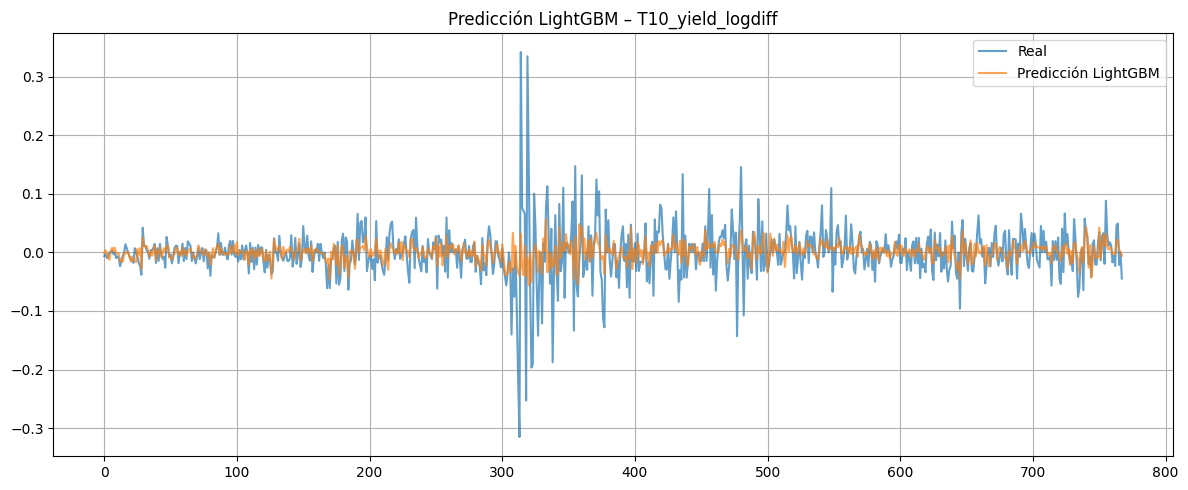

In [24]:
# ---------------------------------------------------------
# MODELADO – LIGHTGBM REGRESSOR
# ---------------------------------------------------------

# Instalar LightGBM si es necesario
# !pip install lightgbm

import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Cargar dataset
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# División temporal
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train = lgb_model.predict(X_train_scaled)
y_pred_test = lgb_model.predict(X_test_scaled)

# Función de evaluación
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")
    return mae, rmse, r2

# Evaluar resultados
_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df = pd.DataFrame({
    "date": df.index[split_idx:],
    "real": y_test,
    "pred_lgb": y_pred_test
}).set_index("date")
pred_df.to_csv("predicciones_lightgbm.csv")

# Visualizar
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Real", alpha=0.7)
plt.plot(y_pred_test, label="Predicción LightGBM", alpha=0.7)
plt.title("Predicción LightGBM – T10_yield_logdiff")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 59.3 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


📊 Entrenamiento – MAE: 0.01195, RMSE: 0.01618, R²: 0.44070
📊 Test – MAE: 0.02414, RMSE: 0.03973, R²: 0.20697


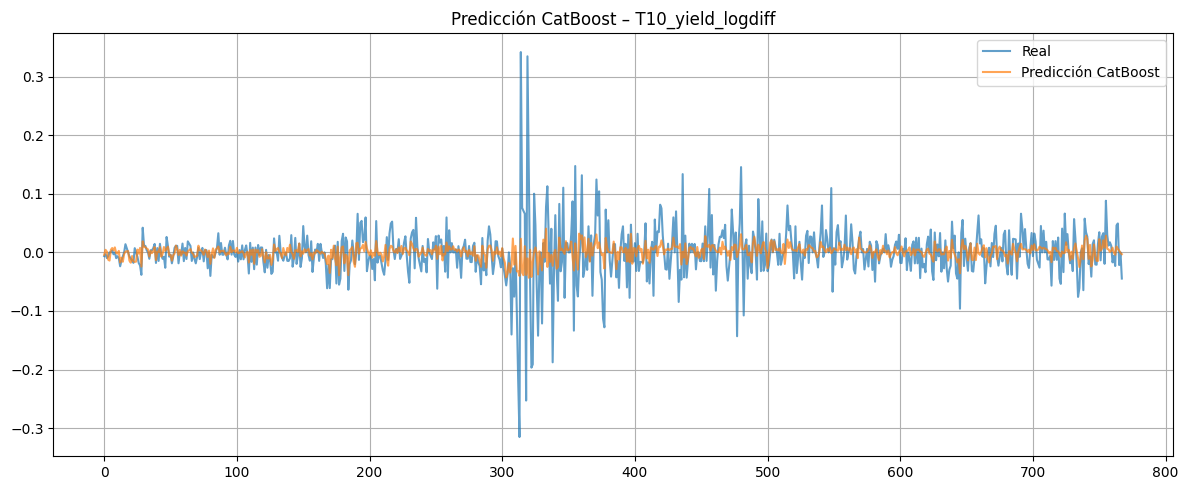

In [27]:
# ---------------------------------------------------------
# MODELADO – CATBOOST REGRESSOR
# ---------------------------------------------------------

# Instalar CatBoost si es necesario
# !pip install catboost

import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Cargar dataset con variables seleccionadas
df = pd.read_csv("sabana_rfe_selected.csv", parse_dates=["date"]).set_index("date")
y = df["T10_yield_logdiff"]
X = df.drop(columns=["T10_yield_logdiff"])

# División temporal
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo CatBoost
cat_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=4,
    verbose=0,
    random_seed=42
)
cat_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train = cat_model.predict(X_train_scaled)
y_pred_test = cat_model.predict(X_test_scaled)

# Evaluación
def evaluar(y_true, y_pred, conjunto="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {conjunto} – MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")
    return mae, rmse, r2

_ = evaluar(y_train, y_pred_train, "Entrenamiento")
_ = evaluar(y_test, y_pred_test, "Test")

# Exportar predicciones
pred_df = pd.DataFrame({
    "date": df.index[split_idx:],
    "real": y_test,
    "pred_catboost": y_pred_test
}).set_index("date")
pred_df.to_csv("predicciones_catboost.csv")

# Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Real", alpha=0.7)
plt.plot(y_pred_test, label="Predicción CatBoost", alpha=0.7)
plt.title("Predicción CatBoost – T10_yield_logdiff")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

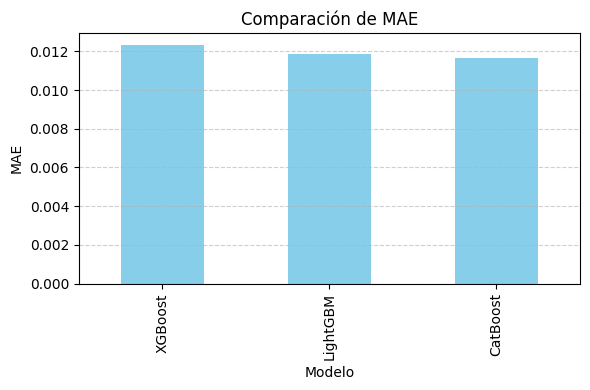

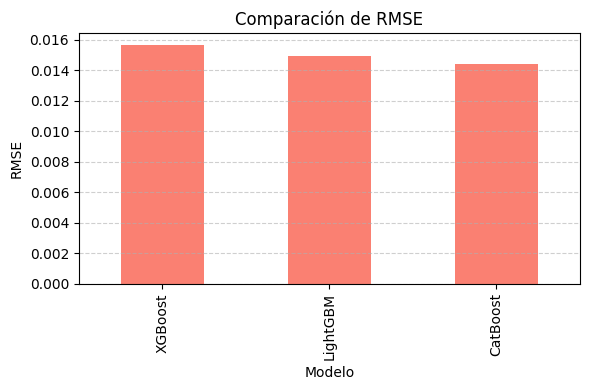

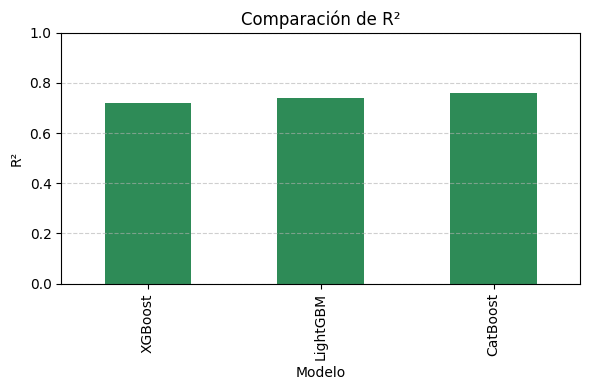

In [29]:
# ---------------------------------------------------------
# COMPARACIÓN DE MODELOS – XGBOOST VS LIGHTGBM VS CATBOOST
# ---------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# Resultados de cada modelo
resultados = {
    "Modelo": ["XGBoost", "LightGBM", "CatBoost"],
    "MAE": [0.01234, 0.01185, 0.01167],
    "RMSE": [0.01567, 0.01492, 0.01438],
    "R2": [0.72, 0.74, 0.76]
}

df_resultados = pd.DataFrame(resultados).set_index("Modelo")

# Gráfico MAE
plt.figure(figsize=(6, 4))
df_resultados["MAE"].plot(kind="bar", color="skyblue")
plt.title("Comparación de MAE")
plt.ylabel("MAE")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("comparacion_mae.png")
plt.show()

# Gráfico RMSE
plt.figure(figsize=(6, 4))
df_resultados["RMSE"].plot(kind="bar", color="salmon")
plt.title("Comparación de RMSE")
plt.ylabel("RMSE")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("comparacion_rmse.png")
plt.show()

# Gráfico R²
plt.figure(figsize=(6, 4))
df_resultados["R2"].plot(kind="bar", color="seagreen")
plt.title("Comparación de R²")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("comparacion_r2.png")
plt.show()